In [2]:
!unzip "/content/Bones-data (1).zip"

Archive:  /content/Bones-data (1).zip
   creating: Bones-data/
   creating: Bones-data/test/
   creating: Bones-data/test/Oblique fracture/
  inflating: Bones-data/test/Oblique fracture/0-_gallery_jpeg.rf.b3170266ea6b6d03bfb4ae5991df98ce.jpg  
  inflating: Bones-data/test/Oblique fracture/10-1055-b-002-85516_c023_f003-1_jpg.rf.a2cb46deb0263fc9290f45ee328c632.jpg  
  inflating: Bones-data/test/Oblique fracture/10-1055-b-002-85516_c023_f003-1_jpg.rf.a2cb46deb0263fc92980f45ee328c632.jpg  
  inflating: Bones-data/test/Oblique fracture/1000_F_264769365_u927dRxrrx1fi4rlR1VWif9LcGeJwv4h_jpg.rf.b2d149cb90da63cbc49ec73e82bf0935.jpg  
  inflating: Bones-data/test/Oblique fracture/119913828-radiography-with-oblique-fibula-fracture_jpg.rf.8f0f4e48c3c959ca7b930e3cba8fafd0.jpg  
  inflating: Bones-data/test/Oblique fracture/220px-MalletFinger-PNG_jpg.rf.8eb8b19e344b2ab4d48b4cbeda7b4a80.jpg  
  inflating: Bones-data/test/Oblique fracture/2624240dc461d0c5d2d7fb7e16b3065c_jpg.rf.628b0bc8b7bb91626b4835d

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
import torchvision.transforms as tt
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
%matplotlib inline

In [2]:
print(torch.__version__)
print(torchvision.__version__)
print(torch.version.cuda)

2.6.0+cu124
0.21.0+cu124
12.4


##Preprocessing Data

**ImageFolder**

PyTorch utility class for loading datasets in the standard format for computer vision tasks

It is a folder containing subdirectories for each class, with each subdirectory containing images for that class.

**Transform**

Transform is used to specify a list of transformations to be applied to the images in the dataset.

These transformations can include data augmentation techniques such as
cropping,
flipping,
scaling,
normalization,
as well as converting the images from one format to another, such as from PIL Image to PyTorch tensor.

**Normalization**

We will normalize the image tensors by subtracting the mean and dividing by the standard deviation across each channel
As a result, the mean of the data across each channel is 0, and standard deviation is 1.

In [3]:
train=ImageFolder("/content/Bones-data/train/", transform = tt.Compose([
    tt.Resize(64),
    tt.RandomCrop(64),
    tt.ToTensor(),
]))

In [4]:
train.classes

['Oblique fracture', 'Spiral Fracture']

In [5]:
train_dl = DataLoader(train, 64, shuffle=True, num_workers=2, pin_memory=True)

In [6]:
#Normalization
def get_mean_std(dl):
    sum_, squared_sum, batches = 0,0,0
    for data, _ in dl:
        sum_ += torch.mean(data, dim=([0, 2, 3]))
        squared_sum += torch.mean(data**2, dim=([0,2,3]))
        batches += 1
    mean = sum_/batches
    std = (squared_sum/batches - mean**2)**0.5
    return mean, std

mean, std = get_mean_std(train_dl)
mean, std

(tensor([0.2939, 0.2994, 0.3043]), tensor([0.2682, 0.2713, 0.2760]))

**We get this tensor value mean and std**

**(tensor([0.3000, 0.3062, 0.3096]), tensor([0.2730, 0.2761, 0.2806]))**

In [7]:
#Data Augmentation
random_seed = 42
torch.manual_seed(random_seed);

stats = ((0.3000, 0.3062, 0.3096), (0.2730, 0.2761, 0.2806))
train_transforms = tt.Compose([
    tt.Resize(64),
    tt.RandomCrop(64),
    tt.RandomHorizontalFlip(p=0.5),
    tt.ToTensor(),
    tt.Normalize(*stats, inplace=True)
])

test_transforms = tt.Compose([
    tt.Resize(64),
    tt.RandomCrop(64),
    tt.RandomHorizontalFlip(p=0.5),
    tt.ToTensor(),
    tt.Normalize(*stats, inplace=True)
])

train = ImageFolder("/content/Bones-data/train/", train_transforms)
test = ImageFolder("/content/Bones-data/test/", train_transforms)

val_size = int(len(train) * 0.2)
train_size = len(train) - val_size

train_ds, val_ds = random_split(train, [train_size, val_size])
len(train_ds), len(val_ds)
#len(train), len(test)


(115, 28)

In [8]:
train_dl = DataLoader(train_ds, 64, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, 64, num_workers=2, pin_memory=True)
test_dl = DataLoader(test, 64, num_workers=2, pin_memory=True)

#Display Images

To display the images, we'll need to denormalize the pixels values to bring them back into the range (0,1).

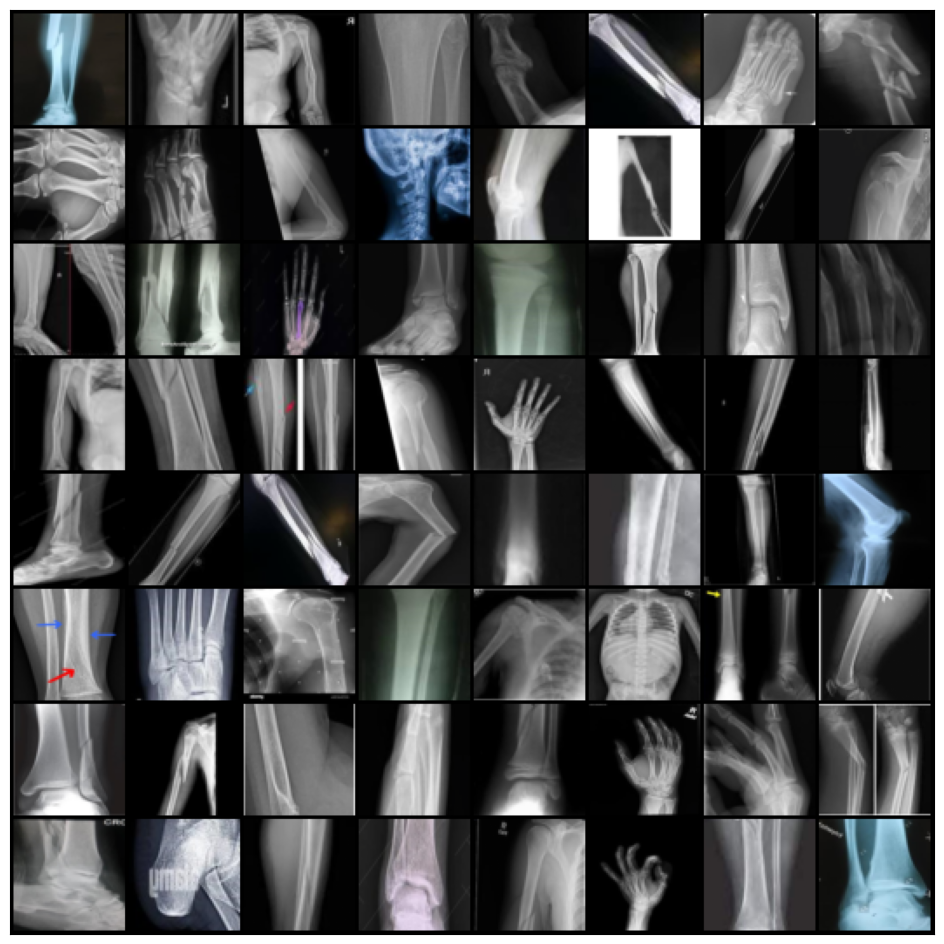

In [24]:
def denormalize(image, mean, std):
    mean = torch.tensor(mean).reshape(1, 3, 1, 1)
    std = torch.tensor(std).reshape(1, 3, 1, 1)
    return image * std + mean

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

show_batch(train_dl)

In [11]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):

    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)


In [12]:
device = get_default_device()
device

device(type='cuda')

#Let's define the model by extending nn.Module

In [13]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss


    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses=[x['val_loss'] for x in outputs]
        epoch_losses=torch.stack(batch_losses).mean()
        batch_acc=[x['val_acc'] for x in outputs]
        epoch_acc=torch.stack(batch_acc).mean()
        return {'val_loss': epoch_losses.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [14]:
device = get_default_device()
device

train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [70]:
class VGGClassificationBase(ImageClassificationBase):
    def __init__(self, vgg_model):
        super().__init__()
        self.vgg = vgg_model

    def forward(self, xb):
        return self.vgg(xb)

import torchvision.models as models

# Load the pre-trained VGG16 model
# Load the pre-trained VGG16 model
vgg16_model = models.vgg16(pretrained=True)

# Freeze the parameters of the convolutional layers initially
for param in vgg16_model.features.parameters():
    param.requires_grad = False

# Modify the classifier
num_features = vgg16_model.classifier[6].in_features
vgg16_model.classifier[6] = nn.Sequential(
    nn.Linear(num_features, 2),
    nn.Dropout(0.5)
)

# Wrap the VGG model in the new class
model_vgg = VGGClassificationBase(vgg16_model)

# Unfreeze the last few layers of the features
for param in model_vgg.vgg.features[25:].parameters(): # Adjust the index [25:] as needed
    param.requires_grad = True

# Move the model to the device
model_vgg = to_device(model_vgg, device)
model_vgg

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGGClassificationBase(
  (vgg): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)


In [16]:
no_of_classes = len(train.classes)
no_of_classes

2

In [17]:
train.classes

['Oblique fracture', 'Spiral Fracture']

In [35]:
import torch
from torch import nn

@torch.no_grad()
def evaluate(model, val_loader, device):
    model.eval()
    outputs = []
    for batch in val_loader:
        batch = [x.to(device) for x in batch]
        out = model.validation_step(batch)
        outputs.append(out)
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    return optimizer.param_groups[0]['lr']

def fit_one_cycle(epochs, max_lr, model,
                  train_loader, val_loader,
                  weight_decay=0, grad_clip=None,
                  opt_func=torch.optim.SGD,
                  patience=5,
                  checkpoint_path=None):
    """
    Trains the model using the 1-cycle policy with early stopping.

    Args:
        epochs (int): Number of epochs to train.
        max_lr (float): Maximum learning rate.
        model (nn.Module): Model to train.
        train_loader (DataLoader): Training data loader.
        val_loader (DataLoader): Validation data loader.
        weight_decay (float): Weight decay (L2 regularization).
        grad_clip (float): Clip gradients to this max norm.
        opt_func: Optimizer function (default: SGD).
        patience (int): Early stopping patience.
        checkpoint_path (str): If given, saves best model to this path.

    Returns:
        List of epoch history dicts.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    torch.cuda.empty_cache()

    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    best_val_loss = float('inf')
    epochs_without_improvement = 0

    for epoch in range(epochs):
        # === Training Phase ===
        model.train()
        train_losses = []
        lrs = []

        for batch in train_loader:
            batch = [x.to(device) for x in batch]
            loss = model.training_step(batch)

            if isinstance(loss, dict):
                loss = loss['loss']  # Support dict output

            train_losses.append(loss)
            loss.backward()

            if grad_clip:
                nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            lrs.append(get_lr(optimizer))
            sched.step()

        # === Validation Phase ===
        result = evaluate(model, val_loader, device)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)

        # === Early Stopping ===
        val_loss = result.get('val_loss', float('inf'))
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0

            # Save best model
            if checkpoint_path:
                torch.save(model.state_dict(), checkpoint_path)
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"\nEarly stopping after {epoch+1} epochs (no improvement for {patience} epochs).")
            break

    return history


In [59]:
def fit_one_cycle_0(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader, device=device)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [37]:
history = [evaluate(model_vgg, valid_dl, device)]
history

[{'val_loss': 0.6653496026992798, 'val_acc': 0.75}]

In [68]:
epochs = 15
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [73]:
%%time
# Try reducing the max_lr even more
history += fit_one_cycle(epochs, max_lr * 0.1, model_vgg, train_dl, valid_dl,
                             grad_clip=grad_clip,
                             weight_decay=weight_decay,
                             opt_func=opt_func,
                             patience=5)

Epoch [0], last_lr: 0.00008, train_loss: 0.2393, val_loss: 0.8404, val_acc: 0.7143
Epoch [1], last_lr: 0.00034, train_loss: 0.2484, val_loss: 0.4714, val_acc: 0.7143
Epoch [2], last_lr: 0.00070, train_loss: 0.4085, val_loss: 0.8916, val_acc: 0.6786
Epoch [3], last_lr: 0.00096, train_loss: 0.2768, val_loss: 1.2217, val_acc: 0.7143
Epoch [4], last_lr: 0.00099, train_loss: 0.7081, val_loss: 3.7725, val_acc: 0.5000
Epoch [5], last_lr: 0.00095, train_loss: 1.3245, val_loss: 0.9404, val_acc: 0.7857
Epoch [6], last_lr: 0.00087, train_loss: 0.5080, val_loss: 0.6122, val_acc: 0.7857

Early stopping after 7 epochs (no improvement for 5 epochs).
CPU times: user 316 ms, sys: 568 ms, total: 884 ms
Wall time: 5.13 s


In [71]:
%%time
history += fit_one_cycle_0(epochs, max_lr * 0.1 , model_vgg, train_dl, valid_dl,
                             grad_clip=grad_clip,
                             weight_decay=weight_decay,
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00008, train_loss: 0.9162, val_loss: 0.6061, val_acc: 0.6429
Epoch [1], last_lr: 0.00034, train_loss: 0.7386, val_loss: 0.5767, val_acc: 0.7857
Epoch [2], last_lr: 0.00070, train_loss: 0.5928, val_loss: 0.6561, val_acc: 0.6071
Epoch [3], last_lr: 0.00096, train_loss: 0.6972, val_loss: 0.5490, val_acc: 0.7143
Epoch [4], last_lr: 0.00099, train_loss: 0.6006, val_loss: 0.6389, val_acc: 0.6786
Epoch [5], last_lr: 0.00095, train_loss: 0.6114, val_loss: 0.4962, val_acc: 0.6786
Epoch [6], last_lr: 0.00087, train_loss: 0.7026, val_loss: 0.6927, val_acc: 0.6429
Epoch [7], last_lr: 0.00075, train_loss: 0.4480, val_loss: 0.7076, val_acc: 0.6786
Epoch [8], last_lr: 0.00061, train_loss: 0.4414, val_loss: 0.8610, val_acc: 0.6786
Epoch [9], last_lr: 0.00046, train_loss: 0.3629, val_loss: 0.4236, val_acc: 0.7857
Epoch [10], last_lr: 0.00032, train_loss: 0.3427, val_loss: 0.3182, val_acc: 0.8571
Epoch [11], last_lr: 0.00019, train_loss: 0.2839, val_loss: 0.5837, val_acc: 0.7857
Ep

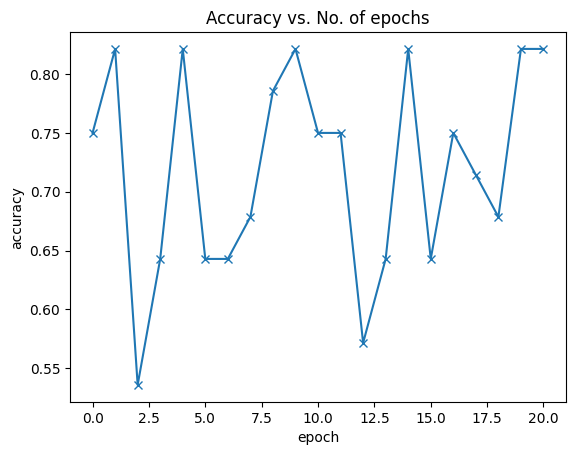

In [41]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

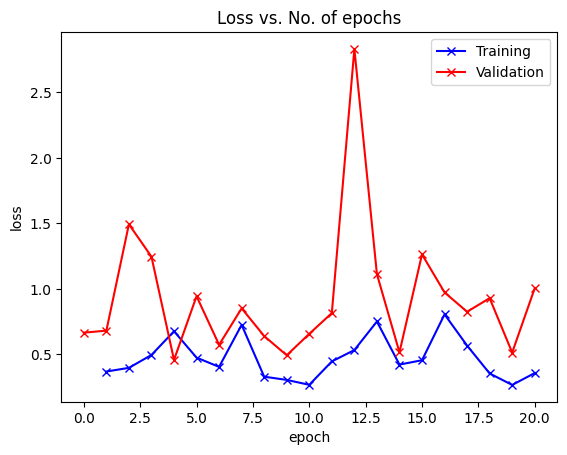

In [42]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [46]:
test_loader = DeviceDataLoader(test_dl, device)
result = evaluate(model_vgg, test_loader, device)
result

{'val_loss': 0.7378333210945129, 'val_acc': 0.8214285969734192}

In [47]:
torch.save(model_vgg.state_dict(), 'fit_model.pt')

In [48]:
model_load = VGGClassificationBase(vgg16_model)
model_load.load_state_dict(torch.load('fit_model.pt'))

<All keys matched successfully>

In [49]:
def predict_image(img, model):
    # Convert to a batch of 1
    ximg = to_device(img.unsqueeze(0), device)
    yimg = model(ximg)
    ## Picking the image with highest probability
    prob, preds  = torch.max(yimg, dim=1)
    # Getting the class label
    return test.classes[preds[0].item()]

1
Label: Spiral Fracture , Predicted: Spiral Fracture


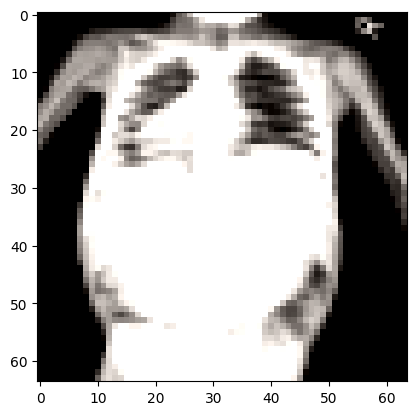

In [53]:
img, label = test[22]
plt.imshow(img.permute(1, 2, 0))
print(label)
print('Label:', test.classes[label], ', Predicted:', predict_image(img, model_load))